# Location-discovery algorithm

This notebook demonstrates the performance of the location-discovery algorithm (both single and batch mode) proposed in the paper, where relevant results can be found in Table 3, Section 5.1.2.

## 1. Preload packages and functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import cvxpy as cp
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import linprog
from scripts.estimation import *
from scripts.utils import *
from scripts.discovery import *

## Synthetic Data Generation

We generate the synthetic data from a Poisson process with an underlying MNL model as rider's choice probability. In this example, all arrival locations are generated from a uniform distribution within a square field inside the location bound.

In [2]:
rand_seed = 1
np.random.seed(rand_seed)
num_position = 10
bike_num = 40
lambd = 10
grid_size = 10
beta0 = 1
beta1_true = -1
T = 100
loc_bound = 5
bike_num,num_records,book_bike,book_index,dist, \
bike_loc,all_period,num_booked,cand_loc,true_loc, \
position_weight=gen_sync(rand_seed,num_position,bike_num,lambd,grid_size,beta0=beta0,beta1_true=beta1_true,T=T,loc_bound=loc_bound)

# Implementation of the Location-Discovery Algorithm

The following snippets implement the location-discovery algorithm under the synthetic data generated above. We randomly initialize two locations and use our location-discovery algorithm to discover potential arrival locations until convergence. After we discover a set of locations, to prevent overfitting, we trim locations where the corresponding weights are less than 0.01.

## Single discovery mode 

The single discovery mode discovers location one at a time.

In [3]:
init_num = 2
cur_locnum = init_num
lkd = np.array([])
lkd = np.append(lkd,-np.inf)
loc_add = np.array([])
init_loc = np.random.uniform(-loc_bound/2,loc_bound/2,(2,2))
cur_loc = init_loc
beta1_cur = beta1_true
pre_w = np.random.uniform(0,1,cur_locnum)
pre_w = pre_w/np.sum(pre_w)
cur_bic = np.inf
pre_bic = np.inf
while (cur_bic<=pre_bic):
    if cur_locnum > init_num:
        cur_loc = np.vstack((cur_loc,loc_add))
        pre_w = cur_w
    cur_dist = caldist(cur_loc,bike_loc,bike_num)
    choice_prob = findchoice_prob(cur_locnum,cur_dist,beta0,beta1_cur,num_records,bike_num)
    cur_w = findw_EM(cur_locnum,cur_loc.reshape(1,-1,2),beta0,bike_num,num_records,bike_loc,book_bike,num_booked,
             book_index,all_period,T)
    cur_lkd = findlkd_no_constraint(cur_locnum,cur_dist,beta0,np.repeat(beta1_cur,cur_locnum).reshape(-1,1),cur_w,
                                    bike_num,num_records,book_bike,book_index,num_booked,all_period)
    lkd = np.append(lkd,cur_lkd)
    pre_bic = cur_bic
    cur_bic = -lkd[-1]+0.5*cur_locnum*np.log(num_booked)
    s = np.sum((1-np.sum(np.expand_dims(cur_w,1)*(1/(1+np.sum(np.exp(beta0+beta1_cur*cur_dist),axis=2))),axis=0))*all_period)
    dist_new = caldist(cand_loc,bike_loc,bike_num)
    grad1 = calgrad(num_booked,s,cand_loc.shape[1],beta0,beta1_cur,choice_prob,all_period,cur_w,dist_new
                    ,bike_num,num_records,book_bike,book_index)
    loc_ind1 = np.argmax(grad1)
    cand_loc2 = gen_loc(loc_bound,grid_size,s=(grid_size-1)/2,coor=cand_loc[0,loc_ind1])
    dist_new = caldist(cand_loc2,bike_loc,bike_num)
    grad2 = calgrad(num_booked,s,cand_loc2.shape[1],beta0,beta1_cur,choice_prob,all_period,cur_w,dist_new
                    ,bike_num,num_records,book_bike,book_index)
    loc_add = cand_loc2[0,np.argmax(grad2)].reshape(1,2)
    cur_locnum = cur_locnum + 1

In [4]:
# Location trimming
thres = 0.01
num_loc = cur_w.shape[0]
disc_lkd = lkd[-1]
sel_ind = cur_w>thres
w_trim = cur_w[sel_ind]/np.sum(cur_w[sel_ind])
was_dist_disc = find_wasserstein(cur_loc[sel_ind,:],true_loc,w_trim,position_weight)
num_remains = np.sum(sel_ind)
trimmed_lkd = findlkd_no_constraint(np.sum(sel_ind),caldist(cur_loc[sel_ind,:],bike_loc,bike_num),\
                                    beta0,np.repeat(beta1_cur,np.sum(sel_ind)).reshape(-1,1),w_trim,
                                    bike_num,num_records,book_bike,book_index,num_booked,all_period)
bic = -trimmed_lkd+0.5*num_remains*np.log(num_booked)
print('Number of discovered locations:', num_remains)
print('The Wasserstein distance is:',was_dist_disc[0])
print('The log-likelihood value is:',trimmed_lkd)
print('The BIC value is:', bic)

Number of discovered locations: 11
The Wasserstein distance is: 2.6855974480427482
The log-likelihood value is: -4447.464471330246
The BIC value is: 4482.498926735801


## Batch Discovery Mode

The batch discovery mode discovers multiple locations at a time that can potentially enlarges the log-likelihood value.

In [5]:
init_num = 2
cur_locnum = init_num
test_stats = np.inf
test_stats_buff = np.inf
lkd = np.array([])
lkd = np.append(lkd,-np.inf)
loc_add = np.array([])
cur_loc = init_loc
beta1_cur = beta1_true
cur_bic = np.inf
pre_bic = np.inf
while (cur_bic<=pre_bic):
  if cur_locnum > init_num:
      cur_loc = np.vstack((cur_loc,loc_add))
      pre_w = cur_w
  cur_dist = caldist(cur_loc,bike_loc,bike_num)
  choice_prob = findchoice_prob(cur_locnum,cur_dist,beta0,beta1_cur,num_records,bike_num)
  cur_w = findw_EM(cur_locnum,cur_loc.reshape(1,-1,2),beta0,bike_num,num_records,bike_loc,book_bike,num_booked,
             book_index,all_period,T)
  cur_lkd = findlkd_no_constraint(cur_locnum,cur_dist,beta0,np.repeat(beta1_cur,cur_locnum).reshape(-1,1),cur_w,
                                  bike_num,num_records,book_bike,book_index,num_booked,all_period)
  lkd = np.append(lkd,cur_lkd)
  pre_bic = cur_bic
  cur_bic = -lkd[-1]+0.5*cur_locnum*np.log(num_booked)
  test_stats = -2*(lkd[-2]-lkd[-1])
  test_stats_buff = test_stats
  s = np.sum((1-np.sum(np.expand_dims(cur_w,1)*(1/(1+np.sum(np.exp(beta0+beta1_cur*cur_dist),axis=2))),axis=0))*all_period)
  dist_new = caldist(cand_loc,bike_loc,bike_num)
  grad1 = calgrad(num_booked,s,cand_loc.shape[1],beta0,beta1_cur,choice_prob,all_period,cur_w,dist_new
                  ,bike_num,num_records,book_bike,book_index)
  loc_ind1 = sel_loc_max(grad1,grid_size)
  num_added = loc_ind1.shape[0]
  loc_add = np.zeros((num_added,2))
  for i,loc_ind in enumerate(loc_ind1):
      cand_loc2 = gen_loc(loc_bound,grid_size,s=(grid_size-1)/2,coor=cand_loc[0,loc_ind])
      dist_new = caldist(cand_loc2,bike_loc,bike_num)
      grad2 = calgrad(num_booked,s,cand_loc2.shape[1],beta0,beta1_cur,choice_prob,all_period,cur_w,dist_new
                      ,bike_num,num_records,book_bike,book_index)
      loc_add[i] = cand_loc2[0,np.argmax(grad2)]
  cur_locnum = cur_locnum + num_added


In [6]:
# Location trimming
thres = 0.01
sel_ind = cur_w>thres
w_trim = cur_w[sel_ind]/np.sum(cur_w[sel_ind])
was_dist_disc = find_wasserstein(cur_loc[sel_ind,:],true_loc,w_trim,position_weight)
num_remains = np.sum(sel_ind)
trimmed_lkd = findlkd_no_constraint(np.sum(sel_ind),caldist(cur_loc[sel_ind,:],bike_loc,bike_num),\
                                    beta0,np.repeat(beta1_true,np.sum(sel_ind)).reshape(-1,1),w_trim,
                                    bike_num,num_records,book_bike,book_index,num_booked,all_period)
bic = -trimmed_lkd+0.5*num_remains*np.log(num_booked)
print('Number of discovered locations:', num_remains)
print('The Wasserstein distance is:',was_dist_disc[0])
print('The log-likelihood value is:',trimmed_lkd)
print('The BIC value is:', bic)

Number of discovered locations: 12
The Wasserstein distance is: 2.0784613476798213
The log-likelihood value is: -4439.900724836441
The BIC value is: 4478.12013073341


# Visualization

We can visualize the predicted locations and the true locations with their corresponding weights over a Cartesian coordinate as follows. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


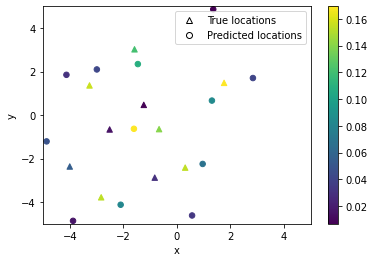

In [7]:
pred_loc = cur_loc[sel_ind,:]
pred_weight = w_trim

plt.scatter(pred_loc[:,0], pred_loc[:,1], c=pred_weight, s=30)
plt.scatter(true_loc[:,0], true_loc[:,1], c=position_weight, marker="^",s=30)
plt.xlim(-loc_bound,loc_bound)
plt.ylim(-loc_bound,loc_bound)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.colorbar()

blue_star = mlines.Line2D([], [], color='black', marker='^', linestyle='None', fillstyle='none',
                          markersize=6, label='True locations')
red_square = mlines.Line2D([], [], color='black', marker='o', linestyle='None',fillstyle='none',
                          markersize=6, label='Predicted locations')

plt.legend(handles=[blue_star, red_square])

plt.show()

# Extension: Jointly estimate w and beta1
We extend the above algorithm to jointly estimate the weight vector `w` and the slope `beta1` in the MNL model. All other setups are the same as before.

## Single Discovery Mode

In [8]:
init_num = 2
cur_locnum = init_num
lkd = np.array([])
conv = False
lkd = np.append(lkd,-np.inf)
loc_add = np.array([])
cur_loc = np.random.uniform(-loc_bound/2,loc_bound/2,(2,2))

beta1_cur = np.random.uniform(-10,0)
beta1_rec = np.array([beta1_cur])
beta1_diff = np.inf
pre_w = np.random.uniform(0,1,cur_locnum)
pre_w = pre_w/np.sum(pre_w)
cur_bic = np.inf
pre_bic = np.inf
while (cur_bic<=pre_bic) or (beta1_diff>0.05) or (cur_locnum<=5):
    if cur_locnum > init_num:
        cur_loc = np.vstack((cur_loc,loc_add))
        pre_w = cur_w
    cur_dist = caldist(cur_loc,bike_loc,bike_num)
    choice_prob = findchoice_prob(cur_locnum,cur_dist,beta0,beta1_cur,num_records,bike_num)
    beta1_cur,cur_w = findbetaw_EM(cur_locnum,cur_loc.reshape(1,-1,2),beta0,beta1_cur,
                                   bike_num,num_records,bike_loc,book_bike,num_booked,book_index,all_period,T)
    beta1_diff = np.abs(beta1_rec[-1]-beta1_cur)
    beta1_rec = np.append(beta1_rec,beta1_cur)
    cur_lkd = findlkd_no_constraint(cur_locnum,cur_dist,beta0,np.repeat(beta1_cur,cur_locnum).reshape(-1,1),cur_w,
                                    bike_num,num_records,book_bike,book_index,num_booked,all_period)
    lkd = np.append(lkd,cur_lkd)
    pre_bic = cur_bic
    cur_bic = -lkd[-1]+0.5*cur_locnum*np.log(num_booked)
    s = np.sum((1-np.sum(np.expand_dims(cur_w,1)*(1/(1+np.sum(np.exp(beta0+beta1_cur*cur_dist),axis=2))),axis=0))*all_period)
    dist_new = caldist(cand_loc,bike_loc,bike_num)
    grad1 = calgrad(num_booked,s,cand_loc.shape[1],beta0,beta1_cur,choice_prob,all_period,cur_w,dist_new
                    ,bike_num,num_records,book_bike,book_index)
    loc_ind1 = np.argmax(grad1)
    cand_loc2 = gen_loc(loc_bound,grid_size,s=(grid_size-1)/2,coor=cand_loc[0,loc_ind1])
    dist_new = caldist(cand_loc2,bike_loc,bike_num)
    grad2 = calgrad(num_booked,s,cand_loc2.shape[1],beta0,beta1_cur,choice_prob,all_period,cur_w,dist_new
                    ,bike_num,num_records,book_bike,book_index)
    loc_add = cand_loc2[0,np.argmax(grad2)].reshape(1,2)
    cur_locnum = cur_locnum + 1

In [9]:
sel_ind = cur_w>0.01
w_trim = cur_w[sel_ind]/np.sum(cur_w[sel_ind])
was_dist_disc = find_wasserstein(cur_loc[sel_ind,:],true_loc,w_trim,position_weight)[0]
num_remains = np.sum(sel_ind)
trimmed_lkd = findlkd_no_constraint(np.sum(sel_ind),caldist(cur_loc[sel_ind,:],bike_loc,bike_num),\
                                    beta0,np.repeat(beta1_cur,np.sum(sel_ind)).reshape(-1,1),w_trim,
                                    bike_num,num_records,book_bike,book_index,num_booked,all_period)
bic = -trimmed_lkd+0.5*num_remains*np.log(num_booked)
print('The MAPE of beta1 is:',np.abs((beta1_cur-beta1_true)/-beta1_true))
print('The Wasserstein distance is:',was_dist_disc)

The MAPE of beta1 is: 0.13105546471578333
The Wasserstein distance is: 2.0266777291269076


## Batch Discovery mode

In [10]:
init_num = 2
cur_locnum = init_num
test_stats = np.inf
test_stats_buff = np.inf
lkd = np.array([])
lkd = np.append(lkd,-np.inf)
loc_add = np.array([])
cur_loc = np.random.uniform(-loc_bound/2,loc_bound/2,(2,2))
beta1_cur = np.random.uniform(-10,0)
beta1_rec = np.array([beta1_cur])
beta1_diff = np.inf
cur_bic = np.inf
pre_bic = np.inf
while (cur_bic<=pre_bic) or (beta1_diff>0.05) or (cur_locnum<=5):
    if cur_locnum > init_num:
        cur_loc = np.vstack((cur_loc,loc_add))
        pre_w = cur_w
    cur_dist = caldist(cur_loc,bike_loc,bike_num)
    choice_prob = findchoice_prob(cur_locnum,cur_dist,beta0,beta1_cur,num_records,bike_num)
    beta1_cur,cur_w = findbetaw_EM(cur_locnum,cur_loc.reshape(1,-1,2),beta0,beta1_cur,
                                   bike_num,num_records,bike_loc,book_bike,num_booked,book_index,all_period,T)
    beta1_diff = np.abs(beta1_rec[-1]-beta1_cur)
    beta1_rec = np.append(beta1_rec,beta1_cur)
    cur_lkd = findlkd_no_constraint(cur_locnum,cur_dist,beta0,np.repeat(beta1_cur,cur_locnum).reshape(-1,1),cur_w,
                                    bike_num,num_records,book_bike,book_index,num_booked,all_period)
    lkd = np.append(lkd,cur_lkd)
    pre_bic = cur_bic
    cur_bic = -lkd[-1]+0.5*cur_locnum*np.log(num_booked)
    s = np.sum((1-np.sum(np.expand_dims(cur_w,1)*(1/(1+np.sum(np.exp(beta0+beta1_cur*cur_dist),axis=2))),axis=0))*all_period)
    dist_new = caldist(cand_loc,bike_loc,bike_num)
    grad1 = calgrad(num_booked,s,cand_loc.shape[1],beta0,beta1_cur,choice_prob,all_period,cur_w,dist_new
                    ,bike_num,num_records,book_bike,book_index)
    loc_ind1 = sel_loc_max(grad1,grid_size)
    num_added = loc_ind1.shape[0]
    loc_add = np.zeros((num_added,2))
    for i,loc_ind in enumerate(loc_ind1):
        cand_loc2 = gen_loc(loc_bound,grid_size,s=(grid_size-1)/2,coor=cand_loc[0,loc_ind])
        dist_new = caldist(cand_loc2,bike_loc,bike_num)
        grad2 = calgrad(num_booked,s,cand_loc2.shape[1],beta0,beta1_cur,choice_prob,all_period,cur_w,dist_new
                        ,bike_num,num_records,book_bike,book_index)
        loc_add[i] = cand_loc2[0,np.argmax(grad2)]
    cur_locnum = cur_locnum + num_added

In [11]:
sel_ind = cur_w>0.01
w_trim = cur_w[sel_ind]/np.sum(cur_w[sel_ind])
was_dist_disc = find_wasserstein(cur_loc[sel_ind,:],true_loc,w_trim,position_weight)[0]
num_remains = np.sum(sel_ind)
trimmed_lkd = findlkd_no_constraint(np.sum(sel_ind),caldist(cur_loc[sel_ind,:],bike_loc,bike_num),\
                                    beta0,np.repeat(beta1_cur,np.sum(sel_ind)).reshape(-1,1),w_trim,
                                    bike_num,num_records,book_bike,book_index,num_booked,all_period)
bic = -trimmed_lkd+0.5*num_remains*np.log(num_booked)
print('The MAPE of beta1 is:',np.abs((beta1_cur-beta1_true)/-beta1_true))
print('The Wasserstein distance is:',was_dist_disc)

The MAPE of beta1 is: 0.1371774577776026
The Wasserstein distance is: 1.8841417585442124
